In [14]:
import torch
def createDataset(input_size,status_size,output_size,slidingWindow):
    u_seq_total = torch.zeros([0,slidingWindow,input_size])
    y_seq_total = torch.zeros([0,output_size])
    ABCD_seq_total = torch.zeros([0,status_size*status_size+status_size*input_size+output_size*status_size+output_size*input_size])
    length = 500
    differentMatrix = 10   #生成多少组不同的ABCD
    ABCD_range = length-slidingWindow-1    #每组ABCD用多少个序列
    for j in range(differentMatrix):
        u_seq = torch.zeros([0,slidingWindow,input_size])
        y_seq = torch.zeros([0,output_size])
        ABCD_seq = torch.zeros([0,status_size*status_size+status_size*input_size+output_size*status_size+output_size*input_size])
        A = torch.randn(status_size,status_size)/status_size
        B = torch.randn(status_size,input_size)/status_size
        C = torch.randn(output_size,status_size)
        D = torch.randn(output_size,input_size)

        u = torch.randn(length,input_size)
        x = torch.zeros(status_size,1)

        for i in range(u.size()[0]):
            y = torch.mm(C,x) + torch.mm(D,u[i].view(input_size,1))
            x = torch.mm(A,x) + torch.mm(B,u[i].view(input_size,1))
            if(i>slidingWindow):
                u_seq = torch.cat([u_seq,u[i-slidingWindow:i].view(1,slidingWindow,input_size)])
                y_seq = torch.cat([y_seq,y.view(1,output_size)])
                ABCD = torch.cat([A.flatten(),B.flatten(),C.flatten(),D.flatten()])
                ABCD_seq = torch.cat([ABCD_seq,ABCD.view(1,ABCD.shape[0])])
        u_seq_total = torch.cat([u_seq_total,u_seq])
        y_seq_total = torch.cat([y_seq_total,y_seq])
        ABCD_seq_total = torch.cat([ABCD_seq_total,ABCD_seq])
    return u_seq_total,y_seq_total,ABCD_seq_total,ABCD_range

def createTestDataset(input_size,status_size,output_size,slidingWindow):
    u_seq = torch.zeros([0,slidingWindow,input_size])
    y_seq = torch.zeros([0,output_size])
    ABCD_seq = torch.zeros([0,status_size*status_size+status_size*input_size+output_size*status_size+output_size*input_size])
    length = 500
    differentMatrix = 60     #生成多少组不同的ABCD
    ABCD_range = length-slidingWindow-1    #每组ABCD用多少个序列
    for j in range(differentMatrix):
        A = torch.randn(status_size,status_size)/status_size
        B = torch.randn(status_size,input_size)/status_size
        C = torch.randn(output_size,status_size)
        D = torch.randn(output_size,input_size)
        ABCD = torch.cat([A.flatten(),B.flatten(),C.flatten(),D.flatten()])
        ABCD_seq = torch.cat([ABCD_seq,ABCD.view(1,ABCD.shape[0])])
        u = torch.randn(length,input_size)
        x = torch.zeros(status_size,1)

        for i in range(u.size()[0]):
            y = torch.mm(C,x) + torch.mm(D,u[i].view(input_size,1))
            x = torch.mm(A,x) + torch.mm(B,u[i].view(input_size,1))
            if(i>slidingWindow):
                u_seq = torch.cat([u_seq,u[i-slidingWindow:i].view(1,slidingWindow,input_size)])
                y_seq = torch.cat([y_seq,y.view(1,output_size)])
    return u_seq,y_seq,ABCD_seq,ABCD_range

In [16]:
import torch.nn as nn
from tqdm import tqdm

class LSTMLinear(nn.Module):
    def __init__(self,input_size,status_size,output_size,slidingWindow):
        super(LSTMLinear,self).__init__()
        self.input_size = input_size
        self.status_size = status_size
        self.output_size = output_size
        self.slidingWindow = slidingWindow
        self.lstm = nn.LSTM(self.input_size,self.input_size,1,batch_first=True,bidirectional=True,dropout=0.2)
        self.fc1 = nn.Linear(self.input_size*self.slidingWindow*2,self.input_size*self.slidingWindow)
        ABCD = status_size*status_size+status_size*input_size+output_size*status_size+output_size*input_size     #ABCD总变量数
        # self.fc2 = nn.Linear(self.input_size*self.slidingWindow*self.output_size,ABCD)
        self.fc2 = nn.Linear(self.input_size*self.slidingWindow+self.output_size, ABCD)
        
    def forward(self,u,y):
        x,_ = self.lstm(u)
        batch,slw,input_feature = x.shape
        x = self.fc1(x.reshape(batch,slw*input_feature))
        x = torch.cat([x, y], 1)
        
        # x_invy = torch.zeros(batch,slw*self.input_size*self.output_size)
        # x_invy = x_invy.cuda()
        # for i in range(batch):
        #     x_invy[i] = torch.mm(torch.pinverse(x[i].view(1,slw*self.input_size)),y[i].view(1,self.output_size)).flatten()
        res = self.fc2(x)
        return res

input_size = 10
status_size = 20
output_size = 10
slidingWindow = 50
assert(input_size == output_size)

(u_seq,y_seq,ABCD_seq,ABCD_range) = createDataset(input_size,status_size,output_size,slidingWindow)
model = LSTMLinear(input_size,status_size,output_size,slidingWindow).cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

num_epochs = 4000
batch_size = 64
pbar = tqdm(range(1, num_epochs+1))

for epoch in pbar:
    if torch.cuda.is_available():
        u_seq = u_seq.cuda()
        y_seq = y_seq.cuda()
        ABCD_seq = ABCD_seq.cuda()
    else:
        u_seq = u_seq
        y_seq = y_seq
        ABCD_seq = ABCD_seq
    for i in range(int(len(u_seq)/batch_size)):
        u = u_seq[i*batch_size:(i+1)*batch_size]
        y = y_seq[i*batch_size:(i+1)*batch_size]
        # 向前传播
        out = model(u,y)
        loss = criterion(out,ABCD_seq[i*batch_size:(i+1)*batch_size])
    
        # 向后传播
        optimizer.zero_grad() # 注意每次迭代都需要清零
        loss.backward()
        optimizer.step()
        pbar.set_postfix({'train loss' : '{0:1.5f}'.format(loss)})

    # if (epoch+1) %1 == 0:
        # print('Epoch[{}/{}], loss:{:.6f}'.format(epoch+1, num_epochs, loss.item()))

100%|██████████| 4000/4000 [21:26<00:00,  3.11it/s, train loss=0.05875]


In [17]:
u_train = u_seq[0:batch_size]
y_train = y_seq[0:batch_size]
target = ABCD_seq[0:batch_size]
u_train = u_train.cuda()
y_train = y_train.cuda()
output = model(u_train, y_train)
print(target)
bias = target - output
print(bias)
print(bias.max(), bias.min())

tensor([[-0.0576, -0.0192,  0.0116,  ..., -1.1905,  1.0220, -1.7723],
        [-0.0576, -0.0192,  0.0116,  ..., -1.1905,  1.0220, -1.7723],
        [-0.0576, -0.0192,  0.0116,  ..., -1.1905,  1.0220, -1.7723],
        ...,
        [-0.0576, -0.0192,  0.0116,  ..., -1.1905,  1.0220, -1.7723],
        [-0.0576, -0.0192,  0.0116,  ..., -1.1905,  1.0220, -1.7723],
        [-0.0576, -0.0192,  0.0116,  ..., -1.1905,  1.0220, -1.7723]],
       device='cuda:0')
tensor([[-0.0456,  0.0561, -0.0520,  ..., -0.7282,  0.4485, -0.7052],
        [ 0.0060,  0.1032, -0.0477,  ..., -0.4754,  0.6884, -0.5951],
        [ 0.0672, -0.0374, -0.0155,  ..., -0.9184,  0.4897, -0.6627],
        ...,
        [ 0.0112,  0.0544,  0.0661,  ...,  0.0127, -0.3699, -0.3754],
        [-0.0313,  0.1051, -0.0638,  ...,  0.0505, -0.3285, -0.3857],
        [-0.0456,  0.0024, -0.0323,  ..., -0.1075, -0.2673, -0.4279]],
       device='cuda:0', grad_fn=<SubBackward0>)
tensor(1.4726, device='cuda:0', grad_fn=<MaxBackward1>) tens

900 900


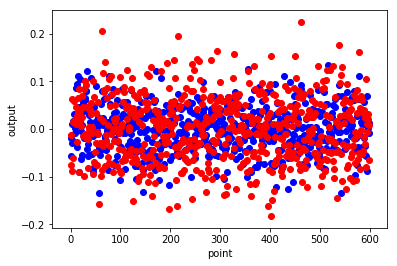

In [18]:
import matplotlib.pyplot as plt
gt_show = [k.cpu().detach().numpy() for k in ABCD_seq[0]]
pred_show = [k.cpu().detach().numpy() for k in output[0]]
print(len(gt_show),len(pred_show))
# train_gt_show = [i.cpu().detach().numpy() for k in train_gt for i in k]
# train_pred_show = [i.cpu().detach().numpy() for k in train_pred for i in k]
length = 600
# plt.scatter(list(range(length)), train_gt_show[0:length], c='b')
# plt.scatter(list(range(length)), train_pred_show[0:length], c='r')
plt.scatter(list(range(length)), gt_show[0:length], c='b')
plt.scatter(list(range(length)), pred_show[0:length], c='r')
plt.xlabel('point')
plt.ylabel('output')
# plt.title(" system_dim {} output_dim {} delay {}".format( system_dim, output_dim, delay))
plt.show()
plt.close()

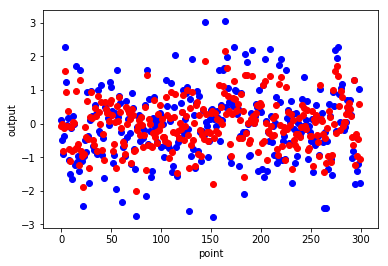

In [19]:
length = 300
# plt.scatter(list(range(length)), train_gt_show[0:length], c='b')
# plt.scatter(list(range(length)), train_pred_show[0:length], c='r')
plt.scatter(list(range(length)), gt_show[600:length+600], c='b')
plt.scatter(list(range(length)), pred_show[600:length+600], c='r')
plt.xlabel('point')
plt.ylabel('output')
# plt.title(" system_dim {} output_dim {} delay {}".format( system_dim, output_dim, delay))
plt.show()
plt.close()

In [ ]:
(u_test_seq,y_test_seq,ABCD_test_seq,ABCD_range) = createTestDataset(input_size,status_size,output_size,slidingWindow)
u = u_test_seq[0:batch_size]
y = y_test_seq[0:batch_size]
u = u.cuda()
y = y.cuda()
output = model(u,y)


In [ ]:
import matplotlib.pyplot as plt
gt_show = [k.cpu().detach().numpy() for k in ABCD_test_seq[0]]
pred_show = [k.cpu().detach().numpy() for k in output[0]]
print(len(gt_show),len(pred_show))
# train_gt_show = [i.cpu().detach().numpy() for k in train_gt for i in k]
# train_pred_show = [i.cpu().detach().numpy() for k in train_pred for i in k]
length = 400
# plt.scatter(list(range(length)), train_gt_show[0:length], c='b')
# plt.scatter(list(range(length)), train_pred_show[0:length], c='r')
plt.scatter(list(range(length)), gt_show[500:length+500], c='b')
plt.scatter(list(range(length)), pred_show[500:length+500], c='r')
plt.xlabel('point')
plt.ylabel('output')
# plt.title(" system_dim {} output_dim {} delay {}".format( system_dim, output_dim, delay))
plt.show()
plt.close()

In [ ]:
import torch
import sys
from data import get_data, gen_label
from tqdm import tqdm
import torch.nn as nn
import math
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
import cv2

class CLSTMModel(torch.nn.Module):
    def __init__(self,feature_num,slidingWindow,InformationAdd=0,InformationLack=0):
        super(CLSTMModel, self).__init__()
        self.feature_num = feature_num
        self.cnn_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(512, self.feature_num)
        )

#         model = models.resnet18(pretrained=True)
# #         model.fc = nn.Identity()
#         self.cnn_layer = model
#         for p in self.parameters():
#             p.requires_grad=False
#         self.cnn_layer.fc = nn.Linear(512,self.feature_num)
        self.slidingWindow = slidingWindow
        self.InformationAdd = InformationAdd
        self.InformationLack = InformationLack
        self.lstm = nn.LSTM(self.feature_num,self.feature_num,1,batch_first=True,bidirectional=True,dropout=0.2)
        self.fc = nn.Linear(self.feature_num*2,1)
        self.slidingFc = nn.Linear(slidingWindow-self.InformationLack+self.InformationAdd,1)
        
        
    def forward(self, u):
        # cnn_x = self.cnn_layer(x)
        # cnn_x = cnn_x.unsqueeze(0)
        x, (h_out, c_out) = self.lstm(u)
        # h = h_out.permute(1, 0, 2)
        # h = h.reshape(h.shape[0], -1)
        # h = self.fc(h)
        
        b,s,h = x.shape
        x = x.reshape(s*b, h) # 转换成线性层的输入格式
        x = self.fc(x)
        x = x.reshape(b,s)
        # x = self.slidingFc(x)
        # x = x.view(b, -1)
        return x
        # return h, h_out, c_out   

slidingWindow = 10
seq_len = 10
InformationAdd = 0
InformationLack = 0
input_size = 10
status_size = 20
output_size = 10
model = CLSTMModel(feature_num, slidingWindow, InformationAdd, InformationLack).cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

batch_size = 256
epochs = 10
delay = 10

pbar = tqdm(range(1, epochs+1))


gen_label(system_dim,output_dim,batch_size,False)  # 改变参数需要重新生成label，设reset=True
train_loader, test_loader = get_data(seq_len, batch_size, delay)
for epoch in pbar:
    # h0 = torch.randn(2, batch_size-slidingWindow, feature_num).cuda()
    # c0 = torch.randn(2, batch_size-slidingWindow, feature_num).cuda()
    for batch_index, (images, labels) in enumerate(train_loader):
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        optimizer.zero_grad()
        loss = criterion(outputs.squeeze(0), labels)
        loss.backward()
        pbar.set_postfix({'train loss' : '{0:1.5f}'.format(loss)})
        optimizer.step()


In [2]:
import torch
def createDataset(input_size,status_size,output_size):
    length = 5000
    y_seq = torch.zeros([length,output_size])

    A = torch.randn(status_size,status_size)/status_size
    B = torch.randn(status_size,input_size)/status_size
    C = torch.randn(output_size,status_size)
    D = torch.randn(output_size,input_size)
    u = torch.randn(length,input_size)
    x = torch.zeros(status_size,1)
    for i in range(length):
        y = torch.mm(C,x) + torch.mm(D,u[i].view(input_size,1))
        x = torch.mm(A,x) + torch.mm(B,u[i].view(input_size,1))
        # u_seq = torch.cat([u_seq,u[i-slidingWindow:i].view(1,slidingWindow,input_size)])
        y_seq[i] = y[:,0]
    return A, B, C, D, u, y_seq

def createTestDataset(input_size,status_size,output_size,slidingWindow):
    u_seq = torch.zeros([0,slidingWindow,input_size])
    y_seq = torch.zeros([0,output_size])
    ABCD_seq = torch.zeros([0,status_size*status_size+status_size*input_size+output_size*status_size+output_size*input_size])
    length = 500
    differentMatrix = 60     #生成多少组不同的ABCD
    ABCD_range = length-slidingWindow-1    #每组ABCD用多少个序列
    for j in range(differentMatrix):
        A = torch.randn(status_size,status_size)/status_size
        B = torch.randn(status_size,input_size)/status_size
        C = torch.randn(output_size,status_size)
        D = torch.randn(output_size,input_size)
        ABCD = torch.cat([A.flatten(),B.flatten(),C.flatten(),D.flatten()])
        ABCD_seq = torch.cat([ABCD_seq,ABCD.view(1,ABCD.shape[0])])
        u = torch.randn(length,input_size)
        x = torch.zeros(status_size,1)

        for i in range(u.size()[0]):
            y = torch.mm(C,x) + torch.mm(D,u[i].view(input_size,1))
            x = torch.mm(A,x) + torch.mm(B,u[i].view(input_size,1))
            if(i>slidingWindow):
                u_seq = torch.cat([u_seq,u[i-slidingWindow:i].view(1,slidingWindow,input_size)])
                y_seq = torch.cat([y_seq,y.view(1,output_size)])
    return u_seq,y_seq,ABCD_seq,ABCD_range

In [11]:
import torch
import sys
from data import get_data, gen_label
from tqdm import tqdm
import torch.nn as nn
import math
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
import cv2

class CLSTMModel(torch.nn.Module):
    def __init__(self,input_size,status_size,output_size,InformationAdd=0,InformationLack=0):
        super(CLSTMModel, self).__init__()
        self.input_size = input_size
        self.status_size = status_size
        # self.cnn_layer = nn.Sequential(
        #     nn.Conv2d(3, 32, kernel_size=3),
        #     nn.ReLU(),
        #     nn.Conv2d(32, 64, kernel_size=3, stride=2),
        #     nn.ReLU(),
        #     nn.Conv2d(64, 64, kernel_size=3, stride=2),
        #     nn.ReLU(),
        #     nn.Conv2d(64, 128, kernel_size=3, stride=2),
        #     nn.ReLU(),
        #     nn.Flatten(),
        #     nn.Linear(512, self.feature_num)
        # )

#         model = models.resnet18(pretrained=True)
# #         model.fc = nn.Identity()
#         self.cnn_layer = model
#         for p in self.parameters():
#             p.requires_grad=False
#         self.cnn_layer.fc = nn.Linear(512,self.feature_num)
        
        self.output_size = output_size
        self.InformationAdd = InformationAdd
        self.InformationLack = InformationLack
        self.lstm = nn.LSTM(self.input_size,self.input_size,1,batch_first=True,bidirectional=True,dropout=0.2)
        self.fc = nn.Linear(self.input_size*2,self.status_size)
        self.fc2 = nn.Linear(self.status_size+input_size, self.output_size)
        self.fc3 = nn.Linear(self.status_size+input_size, self.status_size)
        self.slidingFc = nn.Linear(slidingWindow-self.InformationLack+self.InformationAdd,1)
        
        
    def forward(self, u):
        # cnn_x = self.cnn_layer(x)
        # cnn_x = cnn_x.unsqueeze(0)
        x, (h_out, c_out) = self.lstm(u.unsqueeze(0))
        # h = h_out.permute(1, 0, 2)
        # h = h.reshape(h.shape[0], -1)
        # h = self.fc(h)
        b,s,h = x.shape
        x = x.reshape(s,h) # 转换成线性层的输入格式

        x = self.fc(x)
        x_u = torch.cat([x,u],1)
        y = self.fc2(x_u)
        y = y.reshape(s,self.output_size)
        x_next = self.fc3(x_u)
        x_u_next = torch.cat([x_next[0:-1], u[1:]], 1)
        y_next = self.fc2(x_u_next) 
        # x = self.slidingFc(x)
        # x = x.view(b, -1)
        return x, x_next, y, y_next
        # return h, h_out, c_out   

slidingWindow = 50
seq_len = 10
InformationAdd = 0
InformationLack = 0
input_size = 10
status_size = 20
output_size = 10
model = CLSTMModel(input_size,status_size, output_size, InformationAdd, InformationLack).cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

batch_size = 256
epochs = 5
delay = 10

pbar = tqdm(range(1, epochs+1))

A, B, C, D, u, y_seq = createDataset(input_size,status_size,output_size)
u = u.cuda()
y_seq = y_seq.cuda()
for epoch in pbar:
    # h0 = torch.randn(2, batch_size-slidingWindow, feature_num).cuda()
    # c0 = torch.randn(2, batch_size-slidingWindow, feature_num).cuda()
    for i in range(u.size()[0]-slidingWindow):
        input = u[i:i+slidingWindow]
        y = y_seq[i:i+slidingWindow]
        input = input.cuda()
        y = y.cuda()
        x, x_next, outputs, outputs2 = model(input)
        optimizer.zero_grad()
        loss = criterion(outputs, y)
        loss.backward()
        pbar.set_postfix({'train loss' : '{0:1.5f}'.format(loss)})
        optimizer.step()

100%|██████████| 5/5 [02:28<00:00, 29.72s/it, train loss=0.03158]


In [13]:
w = model.state_dict()["fc2.weight"]
C_pred, D_pred = w.split([status_size, input_size], 1)

w = model.state_dict()["fc3.weight"]
A_pred, B_pred = w.split([status_size, input_size], 1)

In [14]:
# print(A)
print(A - A_pred.cpu())
print(C - C_pred.cpu())
print(D - D_pred.cpu())

tensor([[-1.4514e-01, -1.0739e-01, -1.6737e-01, -1.5973e-01,  1.7996e-01,
          1.0856e-01, -4.5218e-02, -1.3888e-01,  2.4586e-01, -9.2109e-02,
          9.0787e-02, -1.5237e-04, -1.8047e-01, -1.9305e-01, -8.6131e-02,
         -5.0314e-02, -1.8404e-01, -8.0431e-02, -6.7256e-02,  1.6505e-01],
        [-1.3861e-01, -7.0938e-02, -8.3188e-02,  5.9574e-03, -4.4419e-02,
          1.9349e-02,  1.3518e-01, -7.8478e-02, -9.2584e-02,  6.5787e-02,
          5.3992e-02,  2.1458e-01, -1.9632e-01,  1.3920e-01, -4.7793e-02,
          8.2102e-02,  1.5869e-02,  2.2405e-01, -9.9721e-02, -2.4145e-01],
        [-1.6373e-01,  1.5513e-01,  1.3423e-01, -1.4949e-01, -6.1925e-02,
          2.3304e-01, -1.9464e-01,  9.3073e-02, -7.0068e-02,  2.4428e-03,
          1.5369e-01, -1.0601e-01, -6.3697e-03, -9.7026e-02,  8.3274e-02,
         -4.4239e-02,  4.6038e-02, -2.0014e-01, -9.1828e-02,  1.4091e-01],
        [-1.1471e-01,  5.0765e-02,  1.1556e-01, -1.9253e-01,  2.1724e-01,
          4.1787e-02,  1.6174e-01, 

In [2]:
import torch
def gen_data(start=0, len=60, data_num=100):
    x_seq = torch.zeros([0, 1])
    y_seq = torch.zeros([0, 1])
    w_seq = torch.zeros([0])

    for i in range(start+len):
        for j in range(data_num):
            x = torch.randn([1])
            y = (i+1) * x
            x_seq = torch.cat([x_seq, x.view(1,1)])
            y_seq = torch.cat([y_seq, y.view(1,1)])
            a = [i+1]
            w_seq = torch.cat([w_seq, torch.tensor(a).float()])
    return x_seq, y_seq, w_seq


In [3]:
import torch.nn as nn

class LSTMLinear(nn.Module):
    def __init__(self, input_size, output_size, seq_len):
        super(LSTMLinear,self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.seq_len = seq_len
        self.lstm = nn.LSTM(self.input_size, self.input_size, 1, batch_first=True, bidirectional=True, dropout=0.2)
        self.fc = nn.Linear(self.input_size * 2, self.output_size)
        # self.fc1 = nn.Linear(self.input_size*self.slidingWindow*2,self.input_size*self.slidingWindow)
        # self.fc2 = nn.Linear(self.input_size*self.slidingWindow*self.output_size,ABCD)
        
    def forward(self, x):
        x,_ = self.lstm(x)
        x = self.fc(x)
        # batch,slw,input_feature = x.shape
        # x = self.fc(x.reshape(batch,slw*input_feature))
        # x_invy = torch.zeros(batch,slw*self.input_size*self.output_size)
        # x_invy = x_invy.cuda()
        # for i in range(batch):
            # x_invy[i] = torch.mm(torch.pinverse(x[i].view(1,slw*self.input_size)),y[i].view(1,self.output_size)).flatten()
        # res = self.fc2(x_invy)
        return x


In [11]:
from tqdm import tqdm

data_len = 100
x_seq, y_seq, w_seq = gen_data(data_num=data_len)
max = w_seq.max()
min = w_seq.min()
w_seq = (w_seq - min) / (max - min) 
model = LSTMLinear(1, 1, data_len).cuda()
epochs = 300
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

pbar = tqdm(range(1, epochs+1))
for epoch in pbar:
    for i in range(x_seq.size()[0] // data_len):
        x = x_seq[i*data_len: (i+1)*data_len]
        y = y_seq[i*data_len: (i+1)*data_len]
        input = y / x
        # input = torch.cat([x, y], 1)
        input = input.cuda()
        w = w_seq[i*data_len: (i+1)*data_len]
        w = w.cuda()
        outputs = model(input.unsqueeze(0)).squeeze(0).squeeze(1)
        optimizer.zero_grad()
        loss = criterion(outputs, w)
        loss.backward()
        pbar.set_postfix({'train loss' : '{0:1.5f}'.format(loss)})
        optimizer.step()

100%|██████████| 300/300 [02:00<00:00,  2.49it/s, train loss=0.00275]


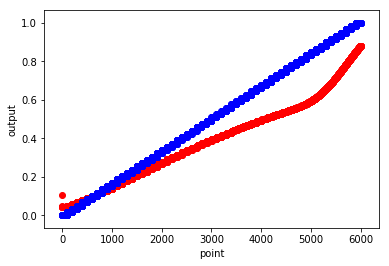

In [16]:
import matplotlib.pyplot as plt

# input = torch.cat([x_seq, y_seq], 1).cuda()
input = y_seq / x_seq
input = input.cuda()
w_pred = model(input.unsqueeze(0)).squeeze(0).squeeze(1)
plt.scatter(range(len(w_pred)), w_pred.cpu().detach().numpy(), c='r')
plt.scatter(range(len(w_seq)), w_seq.numpy(), c='b')
# length = 2000
# plt.scatter(list(range(length)), w_pred.cpu().detach().numpy()[:length], c='r')
# plt.scatter(list(range(length)), w_seq.numpy()[:length], c='b')
# plt.scatter(range(len(w_pred)), w_pred.cpu().detach().numpy() - w_seq.numpy(), c='g')
plt.xlabel('point')
plt.ylabel('output')
# plt.title(" system_dim {} output_dim {} delay {}".format( system_dim, output_dim, delay))
plt.show()
plt.close()


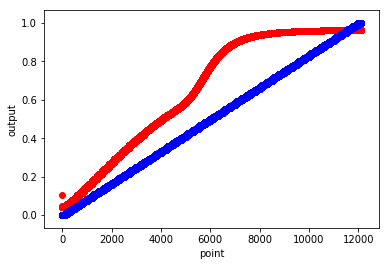

In [14]:
x_seq_test, y_seq_test, w_seq_test = gen_data(start=61)
max = w_seq_test.max()
min = w_seq_test.min()
w_seq_test = (w_seq_test - min) / (max - min) 

import matplotlib.pyplot as plt

# input = torch.cat([x_seq_test, y_seq_test], 1).cuda()
input = y_seq_test / x_seq_test
input = input.cuda()
w_pred_test = model(input.unsqueeze(0)).squeeze(0).squeeze(1)
plt.scatter(range(len(w_pred_test)), w_pred_test.cpu().detach().numpy(), c='r')
plt.scatter(range(len(w_seq_test)), w_seq_test.numpy(), c='b')
# plt.scatter(range(len(w_pred)), w_pred.cpu().detach().numpy() - w_seq.numpy(), c='g')
plt.xlabel('point')
plt.ylabel('output')
# plt.title(" system_dim {} output_dim {} delay {}".format( system_dim, output_dim, delay))
plt.show()
plt.close()


In [30]:
import torch
import torch.nn as nn

input_size = 10
status_size = 20
output_size = 10
seq_len = 2
A = torch.randn(status_size,status_size)/status_size
B = torch.randn(status_size,input_size)/status_size
C = torch.randn(output_size,status_size)
D = torch.randn(output_size,input_size)
print(A)
x = B
for i in range(seq_len):
    x = torch.mm(A, x)
    x = torch.cat([x, B], 1)
x = torch.mm(C, x)
print(x)

# y = C
# for i in range(seq_len+1):
#     if i == 0:
#         y = torch.mm(y, B)
#     else:
#         z = A
#         for j in range(i-1):
#             z = torch.mm(z, A)
#         z = torch.mm(C, z)
#         z = torch.mm(z, B)
#         y = torch.cat([z, y], 1)
# print(y)
# print(x.shape)
# print(y.shape)

class LinearModel(nn.Module):
    def __init__(self,input_size,status_size,output_size, seq_len):
        super(LinearModel, self).__init__()
        self.seq_len = seq_len
        self.b = nn.Linear(status_size, input_size, bias=False)
        self.a = nn.Linear(status_size, status_size, bias=False)
        self.c = nn.Linear(output_size, status_size, bias=False)
    
    def forward(self, x):
        y = x
        x = self.c(x)
        # print("x", x)
        # print("b", self.state_dict()["b.weight"])
        # print(x.shape)
        for i in range(seq_len):
            x = self.a(x)
            x = torch.cat([x, self.c(y)], 0)
        x = self.b(x)
        return x

tensor([[-4.6305e-02, -2.9282e-02,  4.8273e-04,  8.4359e-03,  2.6969e-02,
          9.6945e-02, -1.5691e-02,  5.6131e-02,  3.2922e-02,  2.2430e-03,
          3.4449e-02,  2.2100e-02,  6.1908e-02,  1.1022e-02,  6.5363e-02,
          3.1470e-02, -7.5927e-02, -5.0030e-02, -6.1212e-04, -6.2653e-02],
        [ 3.4039e-02, -1.8272e-02,  4.4407e-02,  2.6357e-02, -5.9662e-02,
         -1.1095e-01, -3.5900e-02, -1.5830e-03,  6.8601e-03, -1.1460e-02,
          2.3388e-02, -1.2934e-01,  3.3986e-03, -3.9219e-02,  3.5575e-02,
          1.1527e-02, -9.2559e-02, -2.6255e-03, -2.5910e-03, -1.2228e-02],
        [ 1.4554e-02, -1.3142e-02,  1.6999e-02, -2.4579e-02, -4.5374e-02,
         -5.1807e-02,  1.1502e-02, -1.4002e-01,  1.8239e-02,  2.4162e-02,
          1.6611e-02,  4.2513e-02,  1.6564e-02, -4.7381e-02,  2.6619e-02,
         -7.3430e-02, -4.0335e-02,  5.1435e-02, -3.6432e-02, -4.1063e-02],
        [ 6.2144e-02,  8.0817e-02,  2.1179e-03,  5.0655e-02,  1.9006e-02,
          3.7529e-02, -1.4383e-02, 

In [31]:
from tqdm import tqdm

model = LinearModel(input_size, status_size, output_size, seq_len).cuda()
epochs = 100000
criterion = nn.MSELoss(reduction = 'sum')
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

u = torch.eye(output_size).cuda()
print(x.shape)
y = x
x = x.chunk(seq_len+1, dim=1)
x = torch.cat(x, 0)
x = x.cuda()
# x = x.permute(1, 0).cuda()
print(x.shape)

pbar = tqdm(range(1, epochs+1))
for epoch in pbar:
    outputs = model(u)
    optimizer.zero_grad()
    loss = criterion(outputs, x)
    loss.backward()
    pbar.set_postfix({'train loss' : '{0:1.8f}'.format(loss)})
    optimizer.step()

  0%|          | 31/100000 [00:00<05:29, 303.59it/s, train loss=5.59250164]torch.Size([10, 30])
torch.Size([30, 10])
100%|██████████| 100000/100000 [04:15<00:00, 391.24it/s, train loss=0.00000000]


In [32]:
A_pred = model.state_dict()["a.weight"].t()
B_pred = model.state_dict()["b.weight"].t()
C_pred = model.state_dict()["c.weight"].t()

print(A - A_pred.cpu())
print(B - B_pred.cpu())
print(C - C_pred.cpu())

tensor([[-0.1525, -0.1635, -0.1191,  0.0375, -0.0838,  0.0540, -0.0121, -0.0674,
          0.1996,  0.1346, -0.1431,  0.2017,  0.1777,  0.0019,  0.0248, -0.0836,
          0.0273,  0.0703,  0.0301,  0.0879],
        [-0.0331, -0.0173,  0.1821,  0.1569,  0.1877, -0.1418, -0.0520, -0.0187,
          0.0464, -0.1025,  0.1435, -0.0722, -0.0094, -0.0295,  0.0133, -0.0722,
          0.1125, -0.0230,  0.0079, -0.0668],
        [ 0.0659, -0.0102,  0.0809, -0.0581,  0.0744, -0.0333, -0.2994, -0.1552,
          0.2641,  0.0616, -0.0457, -0.0633, -0.0017, -0.0222, -0.0605,  0.0784,
          0.1428, -0.0906, -0.1151, -0.0978],
        [ 0.1147, -0.0492,  0.0291,  0.0585,  0.0965, -0.0989,  0.0959,  0.0692,
          0.2770, -0.0170, -0.0807,  0.0290, -0.0273,  0.1424, -0.0493,  0.0395,
         -0.0670,  0.0026, -0.1353, -0.1985],
        [-0.1694,  0.1272,  0.0487,  0.1101, -0.0683,  0.1415,  0.0905,  0.1834,
          0.0294,  0.0244, -0.1904,  0.2188,  0.1183, -0.2582, -0.1079, -0.0977,
      

In [33]:
x_pred = B_pred
for i in range(seq_len):
    x_pred = torch.mm(A_pred, x_pred)
    x_pred = torch.cat([x_pred, B_pred], 1)
x_pred = torch.mm(C_pred, x_pred)
# print(y)
# print(x_pred)
diff = y - x_pred.cpu()
print(diff)
print(torch.max(diff), torch.min(diff))
# print(diff[6])
# print(torch.argmax(diff), torch.argmin(diff))

u = torch.eye(output_size).cuda()
output = model(u)
# print(output)
x_pred = x_pred.chunk(seq_len+1, dim=1)
x_pred = torch.cat(x_pred, 0)

target = y.chunk(seq_len+1, dim=1)
target = torch.cat(target, 0)
diff = target - output.cpu() 
print(diff)
# print(output)
# print(x_pred)
# diff = output - x_pred
# print(diff.max(), diff.min())


tensor([[ 5.0478e-07, -7.7486e-07, -6.2166e-07,  8.3819e-07, -2.1001e-07,
         -7.1153e-07, -2.4401e-07,  3.4273e-07,  9.3132e-08, -1.6810e-07,
         -9.1866e-07,  6.2026e-07, -9.3132e-08, -3.8557e-07,  2.9057e-07,
          1.2666e-06,  1.1688e-06, -6.6310e-07,  1.9129e-06, -7.5437e-07,
          1.8626e-06, -5.4017e-08, -2.1495e-06,  2.6599e-06, -3.2783e-07,
         -3.9488e-07, -2.6822e-07,  2.1383e-06,  1.4920e-06, -5.1968e-07],
        [ 1.2480e-07, -6.6310e-07, -5.9605e-08,  2.1327e-07, -4.1537e-07,
         -3.1240e-07, -4.6846e-07, -1.0408e-07, -7.5216e-07,  4.2934e-07,
         -1.1773e-06,  1.4156e-07,  6.7241e-07, -1.1362e-06, -2.6030e-07,
          1.4678e-06,  3.0082e-07, -9.2015e-07,  1.1772e-06, -7.8231e-08,
          1.7732e-06,  5.3644e-07, -9.0152e-07,  1.0431e-06, -6.6310e-07,
         -3.5763e-07, -9.9465e-07,  1.3113e-06,  8.0466e-07,  2.6822e-07],
        [ 9.9745e-07,  5.7928e-07, -7.9628e-07,  8.9966e-07,  5.4762e-07,
         -4.4890e-07,  1.5460e-07,  

In [2]:
import torch
def createDataset(input_size,status_size,output_size):
    u_seq_total = torch.zeros([0,input_size])
    y_seq_total = torch.zeros([0,output_size])
    differentMatrix = 1   #生成多少组不同的ABCD
    length = 500
    y_seq = torch.zeros([length,output_size])
    ABCD_seq = torch.zeros([0,status_size*status_size+status_size*input_size+output_size*status_size+output_size*input_size])
    for j in range(differentMatrix):
        A = torch.randn(status_size,status_size)/status_size
        B = torch.randn(status_size,input_size)/status_size
        C = torch.randn(output_size,status_size)
        D = torch.randn(output_size,input_size)
        u = torch.randn(length,input_size)
        x = torch.zeros(status_size,1)
        for i in range(length):
            y = torch.mm(C,x) + torch.mm(D,u[i].view(input_size,1))
            x = torch.mm(A,x) + torch.mm(B,u[i].view(input_size,1))
            ABCD = torch.cat([A.flatten(),B.flatten(),C.flatten(),D.flatten()])
            ABCD_seq = torch.cat([ABCD_seq,ABCD.view(1,ABCD.shape[0])])
            y_seq[i] = y[:,0]
        u_seq_total = torch.cat([u_seq_total, u])
        y_seq_total = torch.cat([y_seq_total, y_seq])
    return u_seq_total, y_seq_total, ABCD_seq

input_size = 10
status_size = 20
output_size = 10

u, y, ABCD = createDataset(input_size, status_size, output_size)
print(u.shape)
print(y.shape)

torch.Size([500, 10])
torch.Size([500, 10])


In [7]:
import torch.nn as nn
from tqdm import tqdm

class LSTMLinear(nn.Module):
    def __init__(self,input_size,status_size,output_size,batch_size):
        super(LSTMLinear,self).__init__()
        self.input_size = input_size
        self.status_size = status_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.lstm = nn.LSTM(self.input_size,self.input_size,1,batch_first=True,bidirectional=True,dropout=0.2)
        self.fc1 = nn.Linear(self.input_size*self.batch_size*2, self.input_size*self.batch_size)
        ABCD_size = status_size*status_size+status_size*input_size+output_size*status_size+output_size*input_size     #ABCD总变量数
        self.fc2 = nn.Linear(self.input_size*self.batch_size*self.output_size, ABCD_size)
        # self.fc2 = nn.Linear(self.input_size*self.slidingWindow*self.output_size,ABCD_size)
        
    def forward(self,u,y):
        x, _ = self.lstm(u)
        batch,slw,input_feature = x.shape
        x = self.fc1(x.reshape(batch,slw*input_feature))
        print(x.shape)
        x_invy = torch.zeros(batch,slw*self.input_size*self.output_size)
        x_invy = x_invy.cuda()
        for i in range(batch):
            x_invy[i] = torch.mm(torch.pinverse(x[i].view(1,slw*self.input_size)),y[i].view(1,self.output_size)).flatten()
        res = self.fc2(x_invy)
        return res

        # x = self.fc1(x.reshape(batch,slw*input_feature))
        # x_invy = torch.zeros(batch,slw*self.input_size*self.output_size)
        # x_invy = x_invy.cuda()
        # for i in range(batch):
        #     x_invy[i] = torch.mm(torch.pinverse(x[i].view(1,slw*self.input_size)),y[i].view(1,self.output_size)).flatten()
        # res = self.fc2(x_invy)
        # return res
# input_size = 10
# status_size = 20
# output_size = 10

num_epochs = 10000
batch_size = 64

model = LSTMLinear(input_size,status_size,output_size,batch_size).cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
pbar = tqdm(range(1, num_epochs+1))

for epoch in pbar:
    if torch.cuda.is_available():
        u_seq = u.cuda()
        y_seq = y.cuda()
        ABCD_seq = ABCD.cuda()
    else:
        u_seq = u
        y_seq = y
        ABCD_seq = ABCD
    for i in range(int(len(u_seq)/batch_size)):
        u_input = u_seq[i*batch_size:(i+1)*batch_size].unsqueeze(0)
        y_input = y_seq[i*batch_size:(i+1)*batch_size].unsqueeze(0)
        # 向前传播
        out = model(u_input,y_input).squeeze(0)
        loss = criterion(out, ABCD_seq[i*batch_size:(i+1)*batch_size])
    
        # 向后传播
        optimizer.zero_grad() # 注意每次迭代都需要清零
        loss.backward()
        optimizer.step()
        pbar.set_postfix({'train loss' : '{0:1.5f}'.format(loss)})

    # if (epoch+1) %1 == 0:
        # print('Epoch[{}/{}], loss:{:.6f}'.format(epoch+1, num_epochs, loss.item()))






  0%|          | 0/10000 [00:00<?, ?it/s]torch.Size([1, 640])


RuntimeError: shape '[1, 10]' is invalid for input of size 640

In [8]:
ABCD_pred = model(u[0:batch_size].unsqueeze(0).cuda(), y[0:batch_size].unsqueeze(0).cuda()).squeeze(0)
print(ABCD_seq)
print(ABCD_pred)
bias = ABCD_seq[0:batch_size] - ABCD_pred
print(bias)
print(bias.max(), bias.min())

tensor([[-0.0110,  0.0247,  0.0197,  ..., -0.4761,  0.0963,  0.8610],
        [-0.0110,  0.0247,  0.0197,  ..., -0.4761,  0.0963,  0.8610],
        [-0.0110,  0.0247,  0.0197,  ..., -0.4761,  0.0963,  0.8610],
        ...,
        [-0.0110,  0.0247,  0.0197,  ..., -0.4761,  0.0963,  0.8610],
        [-0.0110,  0.0247,  0.0197,  ..., -0.4761,  0.0963,  0.8610],
        [-0.0110,  0.0247,  0.0197,  ..., -0.4761,  0.0963,  0.8610]],
       device='cuda:0')
tensor([[-0.0655,  0.0439, -0.0368,  ..., -0.4627,  0.0210,  0.5686],
        [-0.0850,  0.0314,  0.0070,  ..., -0.4819,  0.0453,  0.6665],
        [ 0.0158,  0.0538, -0.0109,  ..., -0.5471, -0.0218,  0.7543],
        ...,
        [ 0.0348,  0.0732,  0.0133,  ..., -0.4701,  0.1834,  0.8364],
        [ 0.0830,  0.0763,  0.0503,  ..., -0.4286,  0.0870,  0.7406],
        [ 0.0643,  0.0376,  0.1949,  ..., -0.2874, -0.0376,  0.7142]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([[ 0.0544, -0.0192,  0.0565,  ..., -0.0134,  0.07